## Taking Causal Graph as Input

Temporal causal inference is a difficult problem to solve due to lagged links existing in the graph. Estimating the lag between the parent and action node is quite challenging. In this notebook, we demonstrate the use of temporal shift to normalise temporal datasets and establish causal effects.

In [1]:
import networkx as nx
import pandas as pd
from dowhy.utils.timeseries import create_graph_from_csv,create_graph_from_user
from dowhy.utils.plotting import plot, pretty_print_graph

/home/t-ashutoshs/miniconda3/envs/env_dowhy/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


- The user can either create a csv file with the edges in the graph or input the edges manually


Graph edges with time lags:
1 -> 2 with time-lagged dependency 3
2 -> 3 with time-lagged dependency 4
5 -> 6 with time-lagged dependency 1
4 -> 7 with time-lagged dependency 4
7 -> 6 with time-lagged dependency 3


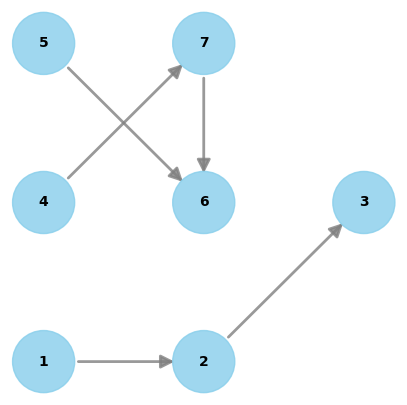

In [2]:
# Prompt user to input the path to the CSV file
file_path = "../../docs/source/example_notebooks/datasets/temporal_graph.csv"

# Create the graph from the CSV file
graph = create_graph_from_csv(file_path)
pretty_print_graph(graph)
plot(graph)

## Dataset Shifting and Preprocessing

In [3]:
from dowhy.timeseries.temporal_shift import find_lagged_parent_nodes,shift_columns,_filter_columns

In [4]:
# read the dataframe in a csv format from the user
dataset_path="../../docs/source/example_notebooks/datasets/temporal_dataset.csv"
dataframe=pd.read_csv(dataset_path)

# the node for which effect estimation has to be done, node:6
target_node = 6

# find the action nodes of the given target node with respective lag times
parents = find_lagged_parent_nodes(graph, target_node)
parents

([5, 7], [1, 3])

In [5]:
time_shifted_df = shift_columns(dataframe,parents[0],parents[1])
time_shifted_df.head()

,1,2,3,4,5,6,7
0,1,2,3,4,0.0,6,0.0
1,2,3,4,5,5.0,7,0.0
2,3,4,5,6,6.0,8,0.0
3,4,5,6,7,7.0,9,7.0
4,0,1,5,7,8.0,9,8.0


In [6]:
filtered_ts_df = _filter_columns(time_shifted_df,target_node,parents[0])
filtered_ts_df.head()

,5,7,6
0,0.0,0.0,6
1,5.0,0.0,7
2,6.0,0.0,8
3,7.0,7.0,9
4,8.0,8.0,9


## Cause Estimation using Dowhy

In [7]:
# perform causal effect estimation on this new dataset
import dowhy
from dowhy import CausalModel

# Assuming 'df' is your DataFrame, 'treatment' is your treatment variable, and 'outcome' is your outcome variable
# Also assuming 'common_causes' is a list of common cause variables

model = CausalModel(
    data=filtered_ts_df,
    treatment='5',
    outcome='6',
    proceed_when_unidentifiable=True  # Proceed even if the causal graph is not fully identifiable
)

identified_estimand = model.identify_effect()

estimate = model.estimate_effect(identified_estimand,
                                 method_name="backdoor.linear_regression",
                                 test_significance=True)

print(estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d        
────(E[6])
d[5]      
Estimand assumption 1, Unconfoundedness: If U→{5} and U→6 then P(6|5,,U) = P(6|5,)

## Realized estimand
b: 6~5
Target units: ate

## Estimate
Mean value: 0.21739130434782616
p-value: [0.24486798]



/home/t-ashutoshs/miniconda3/envs/env_dowhy/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  res = hypotest_fun_out(*samples, **kwds)
/home/t-ashutoshs/home/dowhy/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
